# Analyzing the output of the $S$-matrix generator #

## A NOTE BEFORE STARTING ##

Since the ``prismatique`` git repository tracks this notebook under its original
basename ``analyzing_S_matrix_generator_output.ipynb``, we recommend that you
copy the original notebook and rename it to any other basename that is not one
of the original basenames that appear in the ``<root>/examples`` directory
before executing any of the notebook cells below, where ``<root>`` is the root
of the ``prismatique`` repository. This way you can explore the notebook by
executing and modifying cells without changing the original notebook, which is
being tracked by git.

## Table of contents ##

- [Import necessary modules](#Import-necessary-modules)
- [Introduction](#Introduction)
- [Set paths to files storing output](#Set-paths-to-files-storing-output)
- [Load simulation parameter sets and represent them as Python objects](#Load-simulation-parameter-sets-and-represent-them-as-Python-objects)
- [Extracting sample properties](#Extracting-sample-properties)
  - [Extract the sample unit cell dimensions in units of $\mathring{\mathrm{A}}$](#Extract-the-sample-unit-cell-dimensions-in-units-of-$\mathring{\mathrm{A}}$)
  - [Extract the sample supercell dimensions in units of $\mathring{\mathrm{A}}$](#Extract-the-sample-supercell-dimensions-in-units-of-$\mathring{\mathrm{A}}$)
  - [Extract the lateral dimensions of the sample supercell in units of pixels](#Extract-the-lateral-dimensions-of-the-sample-supercell-in-units-of-pixels)
  - [Extract the lateral pixel size of the sample supercell in units of $\mathring{\mathrm{A}}$](#Extract-the-lateral-pixel-size-of-the-sample-supercell-in-units-of-$\mathring{\mathrm{A}}$)
  - [Extract the number of frozen phonon configuration subsets](#Extract-the-number-of-frozen-phonon-configuration-subsets)
  - [Extract the number of frozen phonon configurations in each subset](#Extract-the-number-of-frozen-phonon-configurations-in-each-subset)
  - [Extract the total number of frozen phonon configurations](#Extract-the-total-number-of-frozen-phonon-configurations)
- [Loading $S$-matrix wavefunctions](#Loading-S-matrix-wavefunctions)

## Import necessary modules ##

In [1]:
# For general array handling.
import numpy as np

# For setting various visualization parameters.
import matplotlib.pyplot as plt

# For loading probe model parameters. Users may receive a warning message about
# ``pyopencl`` upon importing ``embeam``. This message can be safely ignored.
import embeam



# The library that is the subject of this demonstration.
import prismatique

## Introduction ##

In this notebook, we demonstrate how one can analyze select output generated by
the script ``<root>/examples/S_matrix_generator/generate.py``. Said script
generates: the $S$-matrices of the bilayer $\mathrm{MoS}_2$ sample that we
defined
[here](https://mrfitzpa.github.io/prismatique/examples/atomic_coord_generator/generate.html);
the serialized representations of the simulation parameters related to the
modelling of the sample, used to generate the $S$-matrices; the serialized
representation of the simulation parameters related to GPU and CPU workers, used
to generate the $S$-matrices; and the serialized representation of the probe
modelling parameters, used to generate the $S$-matrices. For the current
notebook to work properly, one must first run the aforementioned script.

In order to execute the cells in this notebook as intended, a set of Python
libraries need to be installed in the Python environment within which the cells
of the notebook are to be executed. For this particular notebook, users need to
install:

    pyprismatic>=2.0
    jupyter
    ipympl
    prismatique

The easiest way to install these libraries is within a `conda` virtual
environment. It is recommended that `pyprismatic` be installed separately,
prior to installing any of the other Python libraries listed above. GPU
acceleration is available for `pyprismatic` (and thus `prismatique`) if the
following conditions are met:

1. You are using a Linux or Windows machine that has NVIDIA GPUs.
2. A NVIDIA driver is installed with CUDA version 10.2.89 or greater.

If the above conditions have been met, and you would like to be able to use GPUs
with `prismatique`, run the following command:

    conda install -c conda-forge pyprismatic=2.*=gpu* cudatoolkit==<X>.<Y>.*

where `<X>` and `<Y>` are the major and minor versions of CUDA installed on
your machine, e.g. CUDA version 10.2.89 has a major version of `10`, and a
minor version of `2`. Users can omit `cudatoolkit==<X>.<Y>.*` if they do not
require a specific version of `cudatoolkit`, which should apply to most
scenarios. For CPU support only, run the following command instead:

    conda install -c conda-forge pyprismatic=2.*=cpu*

Once `pyprismatic` is installed, you can install the remaining libraries via
`pip` by running the following command:

    pip install prismatique[examples]

or alternatively, via `conda` by running the following command:

    conda install -c conda-forge prismatique ipympl jupyter

You can find the documentation for the `prismatique` library
[here](https://mrfitzpa.github.io/prismatique/_autosummary/prismatique.html). It
is recommended that you consult the documentation of this library as you explore
the notebook. Moreover, users should execute the cells in the order that they
appear, i.e. from top to bottom, as some cells reference variables that are set
in other cells above them. **Users should make sure to navigate the
documentation for the version of `prismatique` that they are currently using.**

## Set paths to files storing output ##

In [2]:
# Path to file storing the S-matrices of the frozen phonon configuration subset
# #0.
path_to_S_matrix_subset_0 = \
    "../data/S_matrix_generator_output/S_matrices_of_subset_0.h5"

# Path to file storing the S-matrices of the frozen phonon configuration subset
# #1.
path_to_S_matrix_subset_1 = \
    "../data/S_matrix_generator_output/S_matrices_of_subset_1.h5"

# Path to file storing the serialized representation of the simulation
# parameters related to GPU and CPU workers, used to generate the S-matrices.
path_to_worker_params = \
    "../data/S_matrix_generator_output/worker_params.json"

# Path to file storing the serialized representation of the probe modelling
# parameters, used to generate the S-matrices.
path_to_probe_model_params = \
    "../data/S_matrix_generator_output/probe_model_params.json"

## Load simulation parameter sets and represent them as Python objects ##

In [3]:
# Load serialized representation of the worker parameters and represent it as a
# Python object.
worker_params = prismatique.worker.Params.load(path_to_worker_params)

# Load serialized representation of the probe model parameters and represent it
# as a Python object.
cls_alias = embeam.stem.probe.ModelParams
probe_model_params = cls_alias.load(path_to_probe_model_params)

See the documentation for the ``embeam`` library
[here](https://mrfitzpa.gitlab.io/embeam/index.html) for a discussion on how to
use the Python object ``probe_model_params`` along with the ``embeam`` library
to visualize the probe model and calculate various properties of the probe.

## Extracting sample properties ##

Group the paths to the $S$-matrix files into a Python object.

In [4]:
filenames = (path_to_S_matrix_subset_0, path_to_S_matrix_subset_1)
S_matrix_subset_ids = prismatique.sample.SMatrixSubsetIDs(filenames)

### Extract the sample unit cell dimensions in units of $\mathring{\mathrm{A}}$ ###

In [5]:
sample_unit_cell_dims = prismatique.sample.unit_cell_dims(S_matrix_subset_ids)

unformatted_msg = "sample unit cell dimensions (in Å): {}"
msg = unformatted_msg.format(sample_unit_cell_dims)
print(msg)

sample unit cell dimensions (in Å): (22.122800827026367, 21.895893096923828, 15.54092025756836)


### Extract the sample supercell dimensions in units of $\mathring{\mathrm{A}}$ ###

In [6]:
sample_supercell_dims = prismatique.sample.supercell_dims(S_matrix_subset_ids)

unformatted_msg = "sample supercell dimensions (in Å): {}"
msg = unformatted_msg.format(sample_supercell_dims)
print(msg)

sample supercell dimensions (in Å): (22.122800827026367, 21.895893096923828, 15.54092025756836)


### Extract the lateral dimensions of the sample supercell in units of pixels ###

In [7]:
sample_supercell_xy_dims_in_pixels = \
    prismatique.sample.supercell_xy_dims_in_pixels(S_matrix_subset_ids)

unformatted_msg = "lateral dimensions of sample supercell (in pixels): {}"
msg = unformatted_msg.format(sample_supercell_xy_dims_in_pixels)
print(msg)

lateral dimensions of sample supercell (in pixels): (128, 128)


### Extract the lateral pixel size of the sample supercell in units of $\mathring{\mathrm{A}}$ ###

In [8]:
sample_supercell_lateral_pixel_size = \
    prismatique.sample.supercell_lateral_pixel_size(S_matrix_subset_ids)

unformatted_msg = "sample supercell lateral pixel size (in Å): {}"
msg = unformatted_msg.format(sample_supercell_lateral_pixel_size)
print(msg)

sample supercell lateral pixel size (in Å): (0.1728343814611435, 0.1710616648197174)


### Extract the number of frozen phonon configuration subsets ###

In [9]:
num_frozen_phonon_config_subsets = \
    prismatique.sample.num_frozen_phonon_config_subsets(S_matrix_subset_ids)

unformatted_msg = "# frozen phonon configuration subsets: {}"
msg = unformatted_msg.format(num_frozen_phonon_config_subsets)
print(msg)

# frozen phonon configuration subsets: 2


### Extract the number of frozen phonon configurations in each subset ###

This can be done in two ways. The first method involves the use of the function
``prismatique.load.num_frozen_phonon_configs_in_subset``:

In [10]:
func_alias = prismatique.load.num_frozen_phonon_configs_in_subset
filenames = S_matrix_subset_ids.core_attrs["filenames"]

for subset_idx, filename in enumerate(filenames):
    num_frozen_phonon_configs_in_subset = func_alias(filename)
    
    unformatted_msg = "# frozen phonon configurations in subset {}: {}"
    msg = unformatted_msg.format(subset_idx, 
                                 num_frozen_phonon_configs_in_subset)
    print(msg)

# frozen phonon configurations in subset 0: 5
# frozen phonon configurations in subset 1: 5


The second method involves the use of the function
``prismatique.sample.num_frozen_phonon_configs_in_subset``:

In [11]:
func_alias = prismatique.sample.num_frozen_phonon_configs_in_subset

for subset_idx in range(num_frozen_phonon_config_subsets):
    num_frozen_phonon_configs_in_subset = func_alias(S_matrix_subset_ids,
                                                     subset_idx)
    
    unformatted_msg = "# frozen phonon configurations in subset {}: {}"
    msg = unformatted_msg.format(subset_idx, 
                                 num_frozen_phonon_configs_in_subset)
    print(msg)

# frozen phonon configurations in subset 0: 5
# frozen phonon configurations in subset 1: 5


### Extract the total number of frozen phonon configurations ###

In [12]:
total_num_frozen_phonon_configs = \
    prismatique.sample.total_num_frozen_phonon_configs(S_matrix_subset_ids)

unformatted_msg = "total # of frozen phonon configurations: {}"
msg = unformatted_msg.format(total_num_frozen_phonon_configs)
print(msg)

total # of frozen phonon configurations: 10


## Loading $S$-matrix wavefunctions ##

In the code blocks below, we load a subcollection of the $S$-matrix
wavefunctions of one subset.

Load a $S$-matrix wavefunction subcollection into a ``hyperspy`` signal.

In [13]:
kwargs = {"filename": path_to_S_matrix_subset_0, 
          "multi_dim_slice": ([2, 3], slice(1, 8, 2))}

S_matrix_wavefunction_signal, navigational_to_original_indices_map = \
    prismatique.load.S_matrix_wavefunctions(**kwargs)

``navigational_to_original_indices_map`` is a dictionary that maps the
navigational indices of the hyperspy signal ``S_matrix_wavefunction_signal`` to
the original indices specified by ``multi_dim_slice``. For example, if the
original atomic configuration indices map to a set of corresponding navigational
indices, then
``navigational_to_original_indices_map["atomic_config_indices"][i]`` yields the
atomic configuration index specified in the expression
``single_dim_slice=multi_dim_slice[0] if multi_dim_slice is not None else
slice(None)`` that corresponds to the ``i`` th atomic configuration index in the
nagivation index space of ``S_matrix_wavefunction_signal``, where ``i`` is a
nonnegative integer smaller than the total number of atomic configuration
indices specified in ``single_dim_slice``.

In [14]:
navigational_to_original_indices_map

{'atomic_config_indices': (2, 3), 'k_xy_vector_indices': (1, 3, 5, 7)}

Show the $S$-matrix wavefunction signal metadata.

In [15]:
S_matrix_wavefunction_signal.metadata

├── General
│   └── title = S-Matrix Wavefunction
├── Prismatique
└── Signal
    ├── pixel value units = dimensionless
    └── signal_type =

Plot the $S$-matrix wavefunction subcollection.

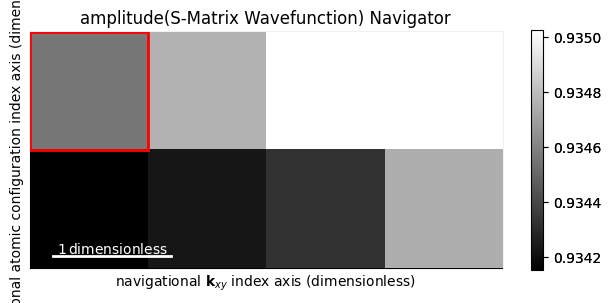

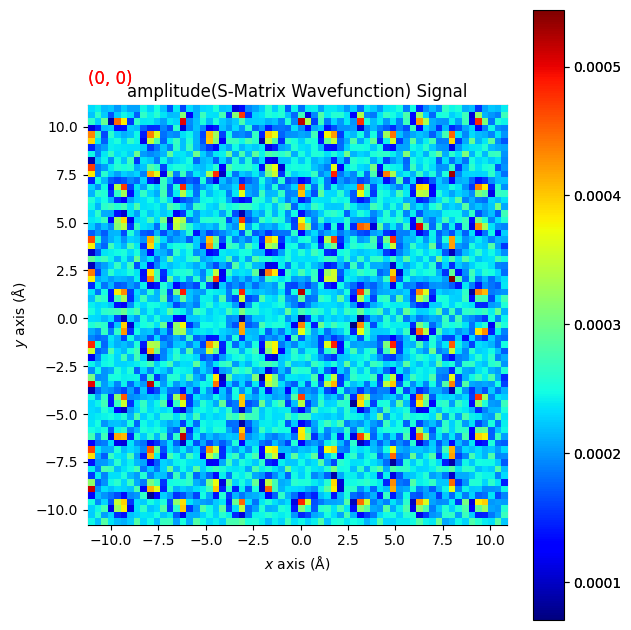

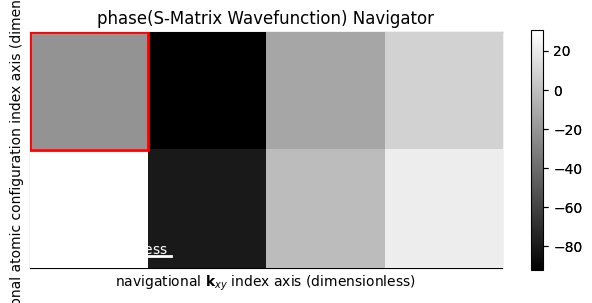

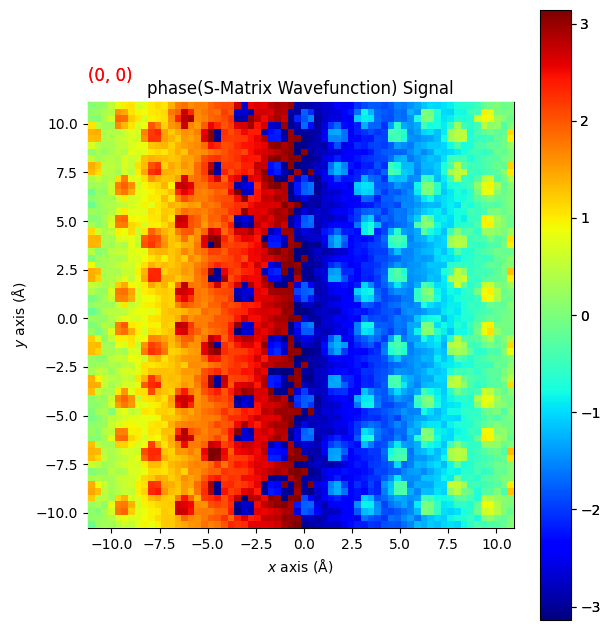

In [16]:
%matplotlib ipympl

kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "gamma": 1,
          "cmap": plt.get_cmap("jet")}
S_matrix_wavefunction_signal.plot(representation="polar", **kwargs)